# wetterdienst - A simple example

pip install wetterdienst

## Import modules necessary for general functioning

In [1]:
from wetterdienst import metadata_for_dwd_data, collect_dwd_data, get_nearest_station
from wetterdienst.enumerations.period_type_enumeration import PeriodType
from wetterdienst.enumerations.time_resolution_enumeration import TimeResolution
from wetterdienst.enumerations.parameter_enumeration import Parameter

import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

## 1. First check the metadata to inform yourself of available stations
(here we pick historical daily precipitation - hdp)

In [2]:
metadata_hdp = metadata_for_dwd_data(
    Parameter.PRECIPITATION_MORE, TimeResolution.DAILY, PeriodType.HISTORICAL)
print("Number of stations with available data: ", metadata_hdp["HAS_FILE"].sum())
print("Some of the stations:")
metadata_hdp.head()

Number of stations with available data:  5620
Some of the stations:


,STATION_ID,FROM_DATE,TO_DATE,STATIONHEIGHT,LAT,LON,STATIONNAME,STATE,HAS_FILE
0,1,1912-01-01,1986-06-30,478.0,47.8413,8.8493,Aach,Baden-Württemberg,True
1,2,1951-01-01,2006-12-31,138.0,50.8066,6.0996,Aachen (Kläranlage),Nordrhein-Westfalen,True
2,3,1891-01-01,2011-03-31,202.0,50.7827,6.0941,Aachen,Nordrhein-Westfalen,True
3,4,1951-01-01,1979-10-31,243.0,50.7683,6.1207,Aachen-Brand,Nordrhein-Westfalen,True
4,6,1982-11-01,2020-07-01,455.0,48.8361,10.0598,Aalen-Unterrombach,Baden-Württemberg,True


The metadata includes an id, the range of the measurements, the position  (including height) as well as place and state of it and if it has a file. With the following plot we want to show a map of those stations:

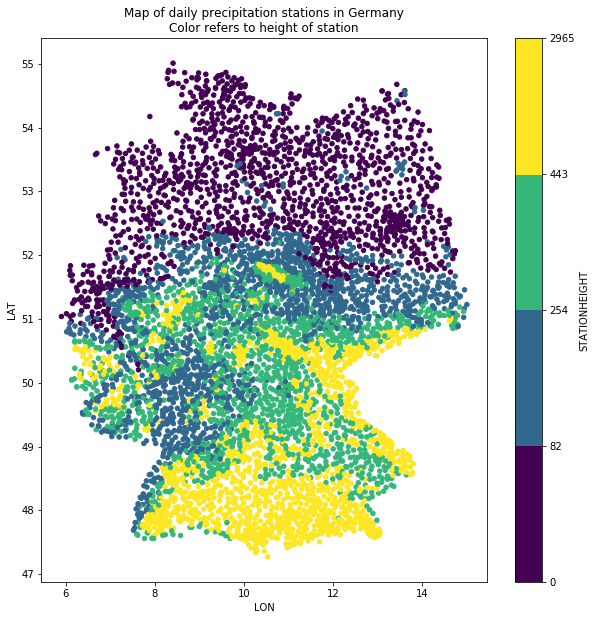

In [3]:
cmap = cm.get_cmap('viridis')
bounds = metadata_hdp.STATIONHEIGHT.quantile([0, 0.25, 0.5, 0.75, 1]).values
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 10))
plot = metadata_hdp.plot.scatter(
    x="LON", y="LAT", c="STATIONHEIGHT", cmap=cmap, norm=norm, ax=ax)
plot.set_title("Map of daily precipitation stations in Germany\n"
               "Color refers to height of station")
plt.show()

## 2. The usual way of retrieving data

Usually there are three steps to follow:
- select indexed files based on
    - its station_id
        - "1048" for Dresden, Germany
    - its parameter
        - "kl" for climate
    - its time_resolution
        - "daily" for daily data
    - its period_type
        - "historical" for data up to the end of the last year
- download the resulting list of files
- parse it into pandas.DataFrames

We have summarized those steps into one:
- collect_dwd_data

Let's try it out for the above selection:

In [4]:
print("Receiving historical daily climate data for Dresden-Klotzsche (1048)")
station_data = collect_dwd_data(
    [1048], Parameter.CLIMATE_SUMMARY, TimeResolution.DAILY, PeriodType.HISTORICAL)

station_data

Receiving historical daily climate data for Dresden-Klotzsche (1048)


,STATION_ID,DATE,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK
0,1048,1934-01-01,NaN,NaN,NaN,1.0,0.2,8.0,NaN,0.0,8.0,6.4,1008.60,0.5,97.00,0.7,0.2,NaN
1,1048,1934-01-02,NaN,NaN,NaN,1.0,0.1,7.0,NaN,0.0,8.0,5.9,1006.20,-0.1,90.00,0.9,-0.8,NaN
2,1048,1934-01-03,NaN,NaN,NaN,1.0,0.0,0.0,NaN,0.0,8.0,5.2,1001.60,-0.7,85.00,-0.1,-1.0,NaN
3,1048,1934-01-04,NaN,NaN,NaN,1.0,0.0,1.0,NaN,0.0,8.0,4.8,1001.40,-1.6,82.00,-0.3,-3.5,NaN
4,1048,1934-01-05,NaN,NaN,NaN,1.0,10.1,8.0,NaN,0.0,5.3,6.3,996.00,0.9,92.00,2.8,-3.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25987,1048,2019-12-27,3.0,8.2,2.9,3.0,0.1,8.0,0.000,0.0,7.7,6.2,999.98,2.5,84.46,3.6,1.3,0.9
25988,1048,2019-12-28,3.0,7.7,3.1,3.0,0.4,7.0,0.000,0.0,7.4,5.2,1011.49,0.4,82.54,1.3,-0.7,-1.0
25989,1048,2019-12-29,3.0,7.7,2.2,3.0,0.0,0.0,6.233,0.0,4.6,4.2,1010.52,-0.5,71.75,2.2,-3.1,-5.4
25990,1048,2019-12-30,3.0,8.7,4.6,3.0,0.0,0.0,1.483,0.0,5.5,4.4,1002.62,2.5,61.08,7.6,-1.0,-2.0


See that DATE is already parsed, so we can easily get some nice graphs with matplotlib, which we will
do in the next part.

## 3. Let's create some plots

First to handle the data easier, we want it to be transformed from tabular to column data,
which means instead of having the data in several columns with an additional date column,
we want three columns, where a set of all three defines the date of measured data, element
and the exact value. To make it clear look at the following table, which is already transformed.

In [5]:
id_vars = ["STATION_ID", "DATE"]
value_vars = [var for var in station_data.columns if var not in id_vars]
station_data_transformed = station_data.melt(
    id_vars=id_vars, value_vars=value_vars, var_name="ELEMENT", value_name="VALUE")

station_data_transformed.head()

,STATION_ID,DATE,ELEMENT,VALUE
0,1048,1934-01-01,QN_3,NaN
1,1048,1934-01-02,QN_3,NaN
2,1048,1934-01-03,QN_3,NaN
3,1048,1934-01-04,QN_3,NaN
4,1048,1934-01-05,QN_3,NaN


We can create a time series/histogram of some elements to compare the distribution of the values, here for example precipitation and mean temperature:

In [6]:
elements_to_plot = ["RSK", "TMK"]
station_data_filtered = station_data_transformed.loc[
    station_data_transformed["ELEMENT"].isin(elements_to_plot)].\
    sort_values(["STATION_ID", "ELEMENT", "DATE"])

station_data_grouped = station_data_filtered.groupby("ELEMENT")["DATE", "VALUE"] #.plot(x="DATE", y="VALUE")

C:\Users\benjamin\anaconda3\envs\dev_python_dwd\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


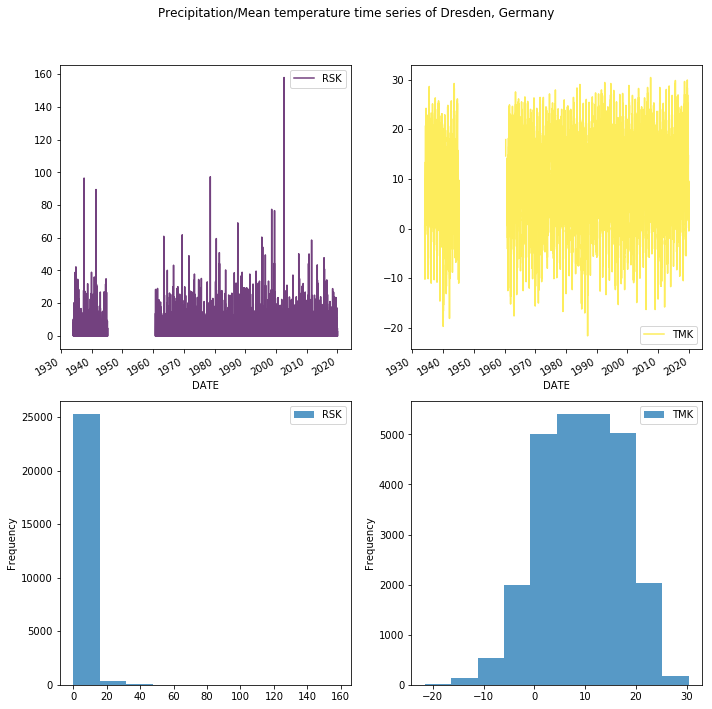

In [7]:
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 2))

fig, axes = plt.subplots(len(elements_to_plot), len(elements_to_plot), figsize=(10, 10))

for (k, v), (ax1, ax2), color in zip(station_data_grouped, axes.T, colors):
    v.plot(x="DATE", y="VALUE", label=k, alpha=.75, ax=ax1, c=color)
    v.plot(y="VALUE", kind="hist", label=k, alpha=.75, ax=ax2)
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Precipitation/Mean temperature time series of Dresden, Germany")

plt.show()

We can see here that the precipitation is completely left-skewed and not normal distributed, while the temperature is almost normaldistributed! Also the timeseries gives a glimpse on how much data is available! Sad notice here is the gap of WW2.

## 4. Create yearly values

In [8]:
for parameter, group in station_data_filtered.groupby("ELEMENT")["DATE", "VALUE"]:
    if parameter == "RSK":
        print(group.groupby(group["DATE"].dt.year)["VALUE"].sum())
    else:
        print(group.groupby(group["DATE"].dt.year)["VALUE"].mean())

DATE
1934    675.6
1935    643.1
1936    555.2
1937    793.7
1938    621.2
        ...  
2015    629.8
2016    721.9
2017    612.3
2018    421.1
2019    503.3
Name: VALUE, Length: 72, dtype: float64
DATE
1934    10.645479
1935     9.053425
1936     8.801366
1937     8.957260
1938     9.021096
          ...    
2015    10.790959
2016    10.081148
2017    10.109315
2018    11.222466
2019    11.229041
Name: VALUE, Length: 72, dtype: float64


C:\Users\benjamin\anaconda3\envs\dev_python_dwd\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


## 5. Find a station

We may want to find a station near to a certain area. Therefor simply call get_nearest_station

In [9]:
get_nearest_station([51.05089], [13.73832], Parameter.CLIMATE_SUMMARY, TimeResolution.DAILY, PeriodType.HISTORICAL)

([1047], [1.3268238814030275])